# Transformer-Based IDS Implementation

### 1. Purpose

This notebook implements a transformer-based Intrusion Detection System (IDS) using the preprocessed dataset produced in 01_dataset_preprocessing.ipynb. Unlike the autoencoder approach, the transformer is trained in a supervised manner on both benign and attack traffic, learning to classify network flows directly.

### 2. Imports

In [7]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 3. Load Processed Dataset

In [8]:
X_train = pd.read_csv("processed/X_train.csv").values
X_val = pd.read_csv("processed/X_val.csv").values
X_test = pd.read_csv("processed/X_test.csv").values

y_train = pd.read_csv("processed/y_train.csv").values.ravel()
y_val = pd.read_csv("processed/y_val.csv").values.ravel()
y_test = pd.read_csv("processed/y_test.csv").values.ravel()

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("\nLabel distribution (Train):")
print(pd.Series(y_train).value_counts().sort_index())
print("\nLabel distribution (Val):")
print(pd.Series(y_val).value_counts().sort_index())
print("\nLabel distribution (Test):")
print(pd.Series(y_test).value_counts().sort_index())

Train shape: (1979513, 77)
Validation shape: (424181, 77)
Test shape: (424182, 77)

Label distribution (Train):
0    1589924
1     389589
Name: count, dtype: int64

Label distribution (Val):
0    340698
1     83483
Name: count, dtype: int64

Label distribution (Test):
0    340698
1     83484
Name: count, dtype: int64


### 4. Transformer Model Architecture

The transformer model treats each feature as a token and uses self-attention to learn relationships between features. This allows the model to capture complex patterns in network traffic.

In [9]:
class PositionalEncoding(nn.Module):
    """Add positional encoding to input features"""
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0), :]
        return x


class TransformerIDS(nn.Module):
    """Transformer-based Intrusion Detection System"""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        # Input projection to d_model
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=input_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        batch_size = x.size(0)

        # Project input to d_model
        x = self.input_projection(x)  # (batch_size, d_model)

        # Reshape for transformer: (seq_len, batch_size, d_model)
        # Treat each feature as a token
        x = x.unsqueeze(0)  # (1, batch_size, d_model)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Apply transformer encoder
        x = self.transformer_encoder(x)  # (1, batch_size, d_model)

        # Global average pooling
        x = x.mean(dim=0)  # (batch_size, d_model)

        # Classification
        x = self.classifier(x)  # (batch_size, 1)

        return x.squeeze(-1)  # (batch_size,)

### 5. Convert to PyTorch Tensors and Create DataLoaders

In [10]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Handle class imbalance with weighted sampling
class_counts = np.bincount(y_train.astype(int))
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train.astype(int)]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 3867
Validation batches: 829
Test batches: 829


### 6. Initialize Model

In [11]:
input_dim = X_train.shape[1]
model = TransformerIDS(
    input_dim=input_dim,
    d_model=128,
    nhead=8,
    num_layers=4,
    dim_feedforward=256,
    dropout=0.1
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 550,273
Trainable parameters: 550,273


### 7. Training Setup

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Using device: cpu


### 8. Training Function

In [14]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy, np.array(all_preds), np.array(all_labels)

### 9. Train Transformer Model

In [16]:
EPOCHS = 20
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_transformer_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print()

# Load best model
model.load_state_dict(torch.load('best_transformer_model.pth'))
print("Loaded best model weights")

Epoch 1/20
  Train Loss: 0.087149, Train Acc: 0.9664
  Val Loss: 0.082788, Val Acc: 0.9618

Epoch 2/20
  Train Loss: 0.080799, Train Acc: 0.9686
  Val Loss: 0.081063, Val Acc: 0.9636

Epoch 3/20
  Train Loss: 0.076710, Train Acc: 0.9701
  Val Loss: 0.078893, Val Acc: 0.9638

Epoch 4/20
  Train Loss: 0.074123, Train Acc: 0.9710
  Val Loss: 0.080372, Val Acc: 0.9637

Epoch 5/20
  Train Loss: 0.071600, Train Acc: 0.9720
  Val Loss: 0.070380, Val Acc: 0.9665

Epoch 6/20
  Train Loss: 0.070220, Train Acc: 0.9725
  Val Loss: 0.074753, Val Acc: 0.9702

Epoch 7/20
  Train Loss: 0.068559, Train Acc: 0.9728
  Val Loss: 0.070098, Val Acc: 0.9684

Epoch 8/20
  Train Loss: 0.066437, Train Acc: 0.9738
  Val Loss: 0.076004, Val Acc: 0.9681

Epoch 9/20
  Train Loss: 0.066116, Train Acc: 0.9741
  Val Loss: 0.070177, Val Acc: 0.9724

Epoch 10/20
  Train Loss: 0.067069, Train Acc: 0.9736
  Val Loss: 0.075324, Val Acc: 0.9646

Epoch 11/20
  Train Loss: 0.066336, Train Acc: 0.9737
  Val Loss: 0.070296, Val

### 10. Training Curves

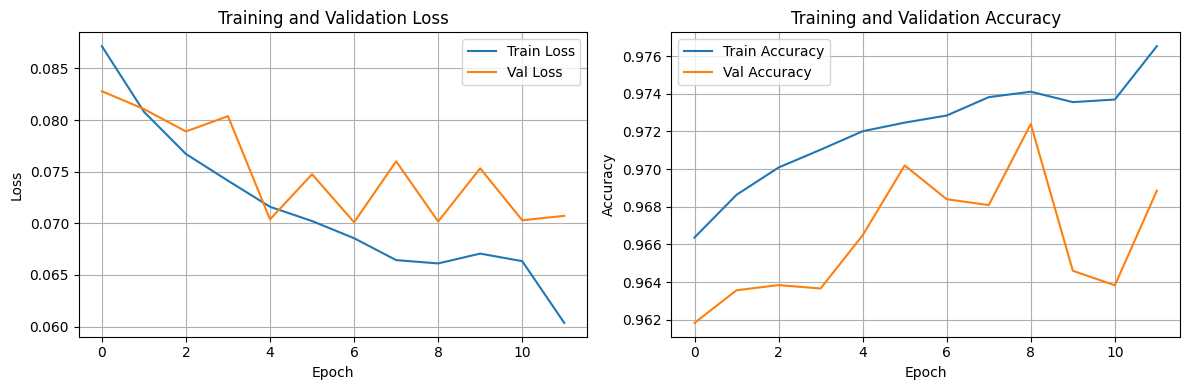

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 11. Evaluation on Test Set

In [18]:
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)
y_pred = (test_preds > 0.5).astype(int)

print(f"Test Loss: {test_loss:.6f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"\nTest AUC-ROC: {roc_auc_score(y_test, test_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Test Loss: 0.069278
Test Accuracy: 0.9687

Test AUC-ROC: 0.9972

Classification Report:
              precision    recall  f1-score   support

           0     0.9971    0.9638    0.9802    340698
           1     0.8701    0.9887    0.9256     83484

    accuracy                         0.9687    424182
   macro avg     0.9336    0.9763    0.9529    424182
weighted avg     0.9721    0.9687    0.9695    424182



### 12. Confusion Matrix

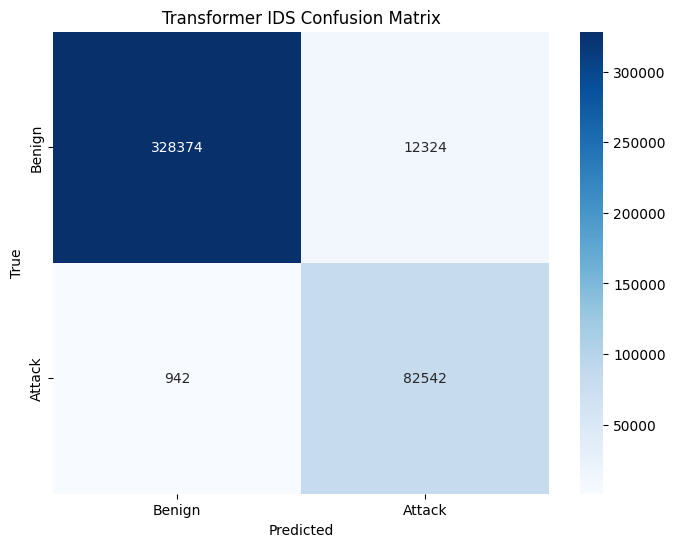

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Transformer IDS Confusion Matrix")
plt.show()

### 13. ROC Curve

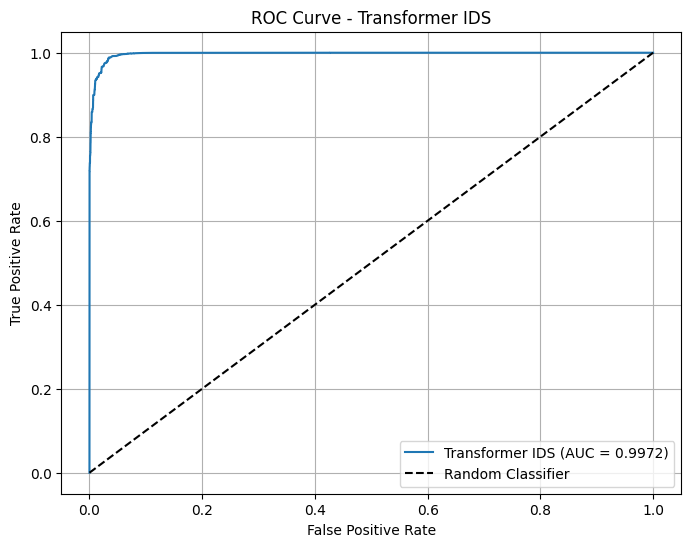

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
auc_score = roc_auc_score(y_test, test_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Transformer IDS (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Transformer IDS')
plt.legend()
plt.grid(True)
plt.show()

### 14. Prediction Probability Distribution

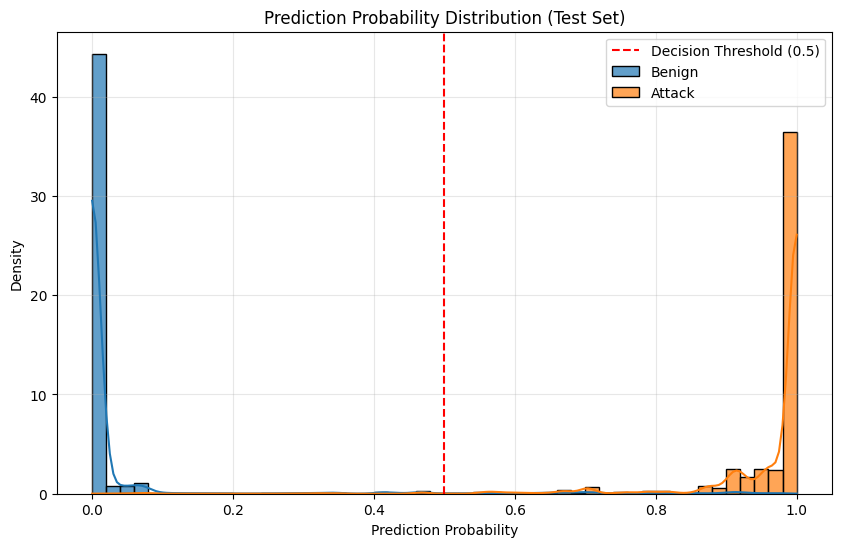

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(test_preds[y_test == 0], bins=50, label="Benign", stat="density", alpha=0.7, kde=True)
sns.histplot(test_preds[y_test == 1], bins=50, label="Attack", stat="density", alpha=0.7, kde=True)
plt.axvline(x=0.5, color='r', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 15. Notes for Report

- The transformer model is trained in a supervised manner on both benign and attack traffic.
- Class imbalance is handled using weighted random sampling during training.
- The model uses self-attention to learn relationships between network flow features.
- Positional encoding is added to help the model understand feature positions.
- Results show the transformer's ability to learn discriminative patterns for intrusion detection.
- The model can be compared with the autoencoder approach to evaluate the benefits of supervised vs. unsupervised learning for IDS.